In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc
from local.optimizer import *
from local.learner import *
from local.callback.progress import *

In [ ]:
#default_exp callback.mixup

# Mixup callback

> Callback to apply MixUp data augmentation to your training

In [ ]:
from local.utils.test import *

## MixupCallback -

In [ ]:
# export
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss    

In [ ]:
# export
from torch.distributions.beta import Beta

class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, alpha = 0.4): self.distrib = Beta(tensor([alpha]), tensor([alpha]))
    
    def begin_fit(self): self.old_loss_func,self.learn.loss_func = self.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.training: return #Only mixup things during training
        lam = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0][:,None,None,None] 
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.learn.xb = torch.lerp(xb1, self.xb, self.lam)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = torch.lerp(loss2, loss1, self.lam)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [ ]:
#test on mnist
from local.vision.core import *

path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = TfmdDS(items, type_tfms=[PILImageBW.create, [parent_label, Categorize()]])
tdl = TfmdDL(tds, tfms=ByteToFloatTensor(), shuffle=True)

mixup = MixUp()
mk_class('_FkLearner', xb=0, loss_func=CrossEntropyLossFlat(), training=True)
mixup.learn = _FkLearner()
mixup('begin_fit')
mixup.xb,mixup.yb = tdl.one_batch()
mixup('begin_batch')

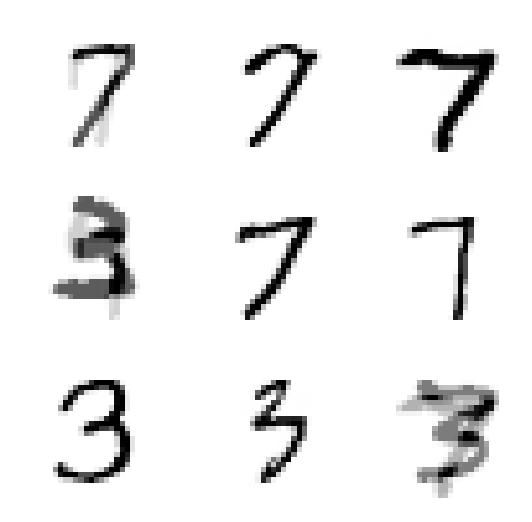

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
tdl.show_batch(b=(mixup.learn.xb,), ctxs=axs.flatten())

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_script.ipynb.
Converted 02_transforms.ipynb.
Converted 03_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 09a_rect_augment.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 18_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 30_text_core.ipynb.
Converted 60_vision_models_xresnet.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
Converted 95_synth_learner.ipynb.
